In [6]:
# Import essential libreries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# pembagian data train, test, dan validasi
train_set = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/Datasets/Diagnosis of Diabetic Retinopathy/train", transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/Datasets/Diagnosis of Diabetic Retinopathy/valid", transform=transform)
val_set.transform
test_set = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/Datasets/Diagnosis of Diabetic Retinopathy/test", transform=transform)
test_set.transform

Compose(
    Resize(size=(255, 255), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

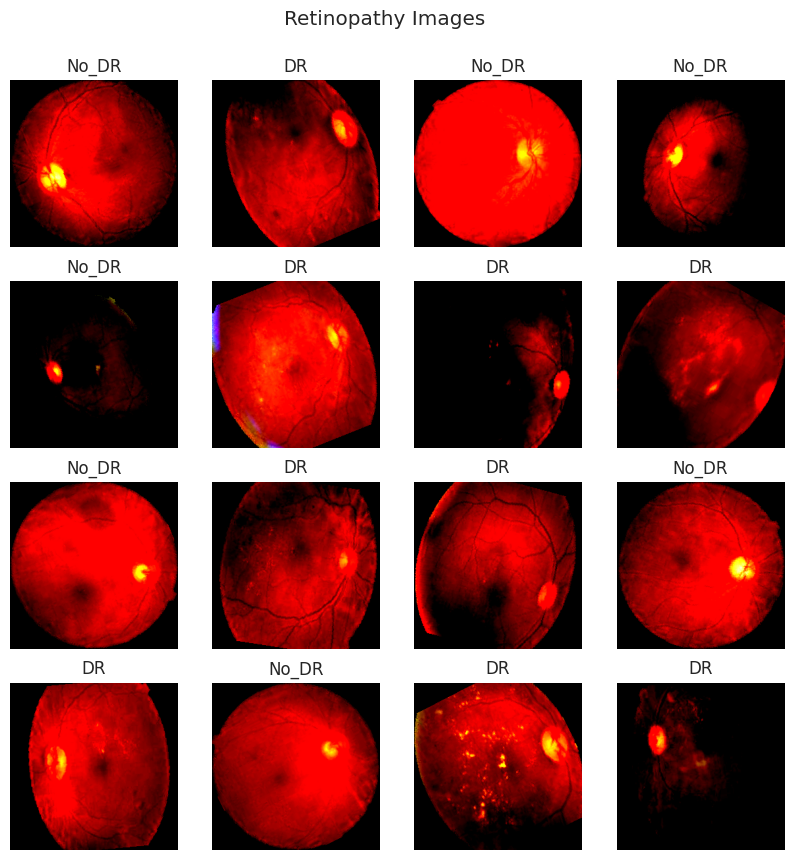

In [5]:
# visualisasi beberapa gambar
import numpy as np

CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # ukuran pixel [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()

In [ ]:
#import data train, test, dab validasi
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [ ]:
# bentuk dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64



In [ ]:
#penghitungan ukuran output dari layer konvo 2D kode dari fungsi phyton
def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [ ]:
# penerapan model arsitektur
class CNN_Retino(nn.Module):

    def __init__(self, params):

        super(CNN_Retino, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # CNN
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        #flatten size
        self.num_flatten=h*w*8*init_f #nilai 8 definisi nilai elemen dalam setiap blok perblok
        self.fc1 = nn.Linear(self.num_flatten, num_fc1) #building layer fully conected layer dengan nama selt.fc1
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [ ]:
params_model={
        "shape_in": (3,255,255),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.15,
        "num_classes": 2}

# membuat inisiasi kelas untuk menampung parameter yang sudah ditentukan
Retino_model = CNN_Retino(params_model)

# mengatur komputasi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Retino_model = Retino_model.to(device)

In [ ]:
summary(Retino_model, input_size=(3, 255, 255),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 253, 253]             224
            Conv2d-2         [-1, 16, 124, 124]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.74
Forward/backward pass size (MB): 7.05
Params size (MB): 4.88
Estimated Total Size (MB): 12.67
----------------------------------------------------------------


In [ ]:
loss_func = nn.NLLLoss(reduction="sum") #parameter untuk menghitung seberapa besar kesalahan dalam prediksi

In [ ]:
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1) #menginisialisasi pengoptimal dan penjadwalan penurunan tingkat

In [ ]:
# parameter mendapatkan learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [ ]:
def train_val(model, params, verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
         # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history


In [ ]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 10,
 "optimiser": optim.Adam(Retino_model.parameters(),lr=1e-4),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=40,verbose=1),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: >

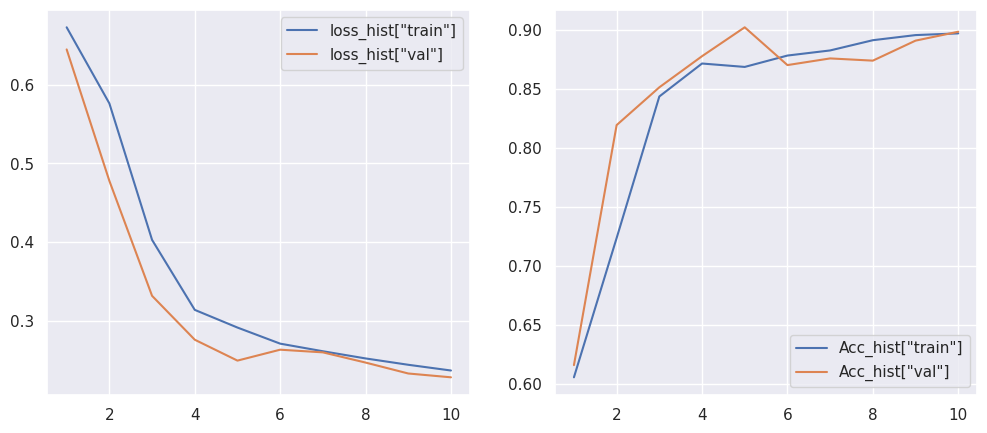

In [ ]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

In [ ]:
# Define Function For Classification Report
def ture_and_pred_data(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

In [ ]:
y_true, y_pred = ture_and_pred_data(train_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      1050
         1.0       0.88      0.92      0.90      1026

    accuracy                           0.90      2076
   macro avg       0.90      0.90      0.90      2076
weighted avg       0.90      0.90      0.90      2076
 




In [ ]:
# # Classification Report for Retinopathy Classification Model based on Validation Set
y_true, y_pred = ture_and_pred_data(val_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

In [ ]:
torch.save(Retino_model, "Retino_model.pt")

In [ ]:
# Load the pretrained model
model = torch.load("Retino_model.pt")

# Move the model to the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Iterate over the test loader for prediction
with torch.no_grad():
    for images, _ in test_loader:

        images = images.to(device)
        output = model(images)
        probabilities = torch.softmax(output, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        for predicted_class in predicted_classes:
            print("Predicted class:", predicted_class.item())

In [ ]:
## Classification Report for Retinopathy Classification Model based on Test set
y_true, y_pred = ture_and_pred_data(test_loader, model)
print(classification_report(y_true, y_pred), '\n\n')